In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
#from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from datasets import load_metric


In [2]:
# Load data
df_train = pd.read_csv(r'C:\Users\sagar\OneDrive\Desktop\Sem 3\Deep Learning\Project 3\to_Transformer_train.csv')
df_val = pd.read_csv(r'C:\Users\sagar\OneDrive\Desktop\Sem 3\Deep Learning\Project 3\to_Transformer_val.csv')

# Reset index
#df_train = df_train.reset_index(drop=True)
#df_val = df_val.reset_index(drop=True)

In [3]:
df_train

,Unnamed: 0,text,source,label,essays_lower,expanded_text,sentences
0,11081,The 28-year-old was a free agent after leaving...,Human,0,the 28-year-old was a free agent after leaving...,the 28-year-old was a free agent after leaving...,['the 28-year-old was a free agent after leavi...
1,11854,Relationship: Communication Between Family Mem...,Human,0,relationship: communication between family mem...,relationship: communication between family mem...,['relationship: communication between family m...
2,24209,RAK Bank Organization in UAE Report\n\nIntrodu...,Human,0,rak bank organization in uae report\n\nintrodu...,rak bank organization in uae report\n\nintrodu...,['rak bank organization in uae report\n\nintro...
3,22650,Good downtown location and open late during wi...,Human,0,good downtown location and open late during wi...,good downtown location and open late during wi...,['good downtown location and open late during ...
4,19915,The Issue of the Partitioning of India into In...,Human,0,the issue of the partitioning of india into in...,the issue of the partitioning of india into in...,['the issue of the partitioning of india into ...
...,...,...,...,...,...,...,...
19995,49468,You never expected your death to be heroic. As...,GPT-3.5,1,you never expected your death to be heroic. as...,you never expected your death to be heroic. as...,"['you never expected your death to be heroic',..."
19996,33831,Had the prix fixe menu featuring Hot Sour Soup...,GPT-3.5,1,had the prix fixe menu featuring hot sour soup...,had the prix fixe menu featuring hot sour soup...,['had the prix fixe menu featuring hot sour so...
19997,41443,Coral reefs are one of the most diverse and im...,GPT-3.5,1,coral reefs are one of the most diverse and im...,coral reefs are one of the most diverse and im...,['coral reefs are one of the most diverse and ...
19998,26481,While it is idealistic to believe that race sh...,GPT-3.5,1,while it is idealistic to believe that race sh...,while it is idealistic to believe that race sh...,"[""while it is idealistic to believe that race ..."


In [4]:
# Display label counts
print("Training label counts:")
print(df_train['label'].value_counts())
print("Validation label counts:")
print(df_val['label'].value_counts())

Training label counts:
label
0    10000
1    10000
Name: count, dtype: int64
Validation label counts:
label
0    500
1    500
Name: count, dtype: int64


In [5]:
# Extract texts and labels
train_texts = df_train['sentences'].tolist()
train_labels = df_train['label'].tolist()
val_texts = df_val['sentences'].tolist()
val_labels = df_val['label'].tolist()


In [6]:

# Preview data
print("Train texts sample:", train_texts[:2])
print("Val texts sample:", val_texts[:2])


Train texts sample: ['[\'the 28-year-old was a free agent after leaving blackpool, where he played 10 times last season as the tangerines were promoted to league one\', \' the ex-blackburn and preston man made the majority of his career appearances at scunthorpe, featuring 137 times\', " nolan has become crewe\'s fourth signing of the summer", " jordan bowery, michael raynes and chris porter have all moved to david artell\'s side this summer", \' find all the latest football transfers on our dedicated page\', \'\']', "['relationship: communication between family members essay\\n\\ntable of contents\\n 1', ' introduction\\n 2', ' relationship\\n 3', ' communication\\n 4', ' conclusion\\n 5', ' works cited\\n\\nintroduction\\n\\nrelations and communications with parents and relatives are one of the most important and fundamental phenomena necessary for the development of an individual', ' thus, this process of communication and interaction between several relatives can be characterized f

In [7]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments, Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(device)

cuda


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set pad_token if not already defined

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few transformer blocks and the classification head
unfreeze_layers = [ 'h.11', 'ln_f', 'score']
for name, param in model.named_parameters():
    if any(layer in name for layer in unfreeze_layers):
        param.requires_grad = True

# Check which parameters are trainable now
for name, param in model.named_parameters():
    print(f"{name}: trainable={param.requires_grad}")

transformer.wte.weight: trainable=False
transformer.wpe.weight: trainable=False
transformer.h.0.ln_1.weight: trainable=False
transformer.h.0.ln_1.bias: trainable=False
transformer.h.0.attn.c_attn.weight: trainable=False
transformer.h.0.attn.c_attn.bias: trainable=False
transformer.h.0.attn.c_proj.weight: trainable=False
transformer.h.0.attn.c_proj.bias: trainable=False
transformer.h.0.ln_2.weight: trainable=False
transformer.h.0.ln_2.bias: trainable=False
transformer.h.0.mlp.c_fc.weight: trainable=False
transformer.h.0.mlp.c_fc.bias: trainable=False
transformer.h.0.mlp.c_proj.weight: trainable=False
transformer.h.0.mlp.c_proj.bias: trainable=False
transformer.h.1.ln_1.weight: trainable=False
transformer.h.1.ln_1.bias: trainable=False
transformer.h.1.attn.c_attn.weight: trainable=False
transformer.h.1.attn.c_attn.bias: trainable=False
transformer.h.1.attn.c_proj.weight: trainable=False
transformer.h.1.attn.c_proj.bias: trainable=False
transformer.h.1.ln_2.weight: trainable=False
transfo

In [10]:
class GPT2Dataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: self.encodings[key][idx] for key in self.encodings}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenization
def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    return GPT2Dataset(encodings, labels)

train_dataset = tokenize_data(train_texts, train_labels)
val_dataset = tokenize_data(val_texts, val_labels)


In [11]:
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [22]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results_finetune_GPT2_Venkat_new',
    num_train_epochs=5,
    per_device_train_batch_size=40,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_finetune_new',
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)



In [23]:
# Custom compute_metrics function for accuracy
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [24]:
# Train the model
trainer.train()




Epoch,Training Loss,Validation Loss,Accuracy
1,0.108600,0.187405,0.925000
2,0.104900,0.084458,0.965000
3,0.083500,0.110475,0.958000
4,0.056500,0.115717,0.957000
5,0.047100,0.114353,0.958000


TrainOutput(global_step=2500, training_loss=0.08652847146987915, metrics={'train_runtime': 2726.6775, 'train_samples_per_second': 36.675, 'train_steps_per_second': 0.917, 'total_flos': 2.61296750592e+16, 'train_loss': 0.08652847146987915, 'epoch': 5.0})

In [27]:
# Save the best model, tokenizer, and configuration
model_path = "./saved_model_GPT2_Venkat_final"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./saved_model_GPT2_Venkat_final\\tokenizer_config.json',
 './saved_model_GPT2_Venkat_final\\special_tokens_map.json',
 './saved_model_GPT2_Venkat_final\\vocab.json',
 './saved_model_GPT2_Venkat_final\\merges.txt',
 './saved_model_GPT2_Venkat_final\\added_tokens.json')

In [25]:
import seaborn as sns

Validation Accuracy: 0.9650
Validation Loss: 0.0845


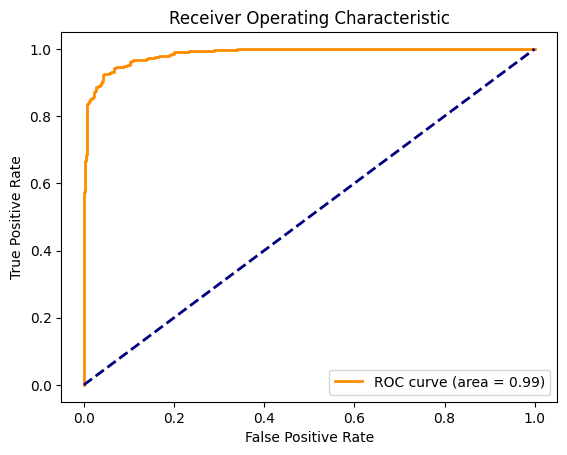

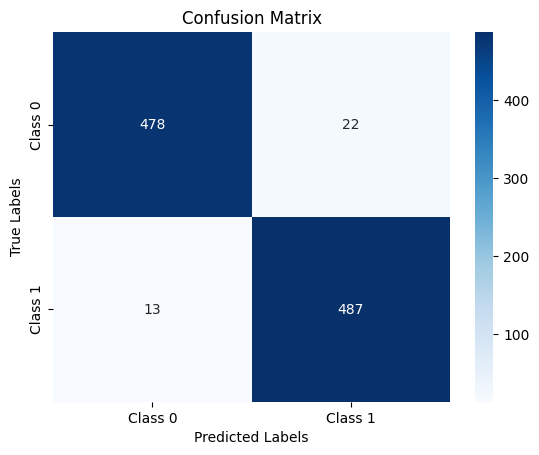

In [26]:
# Evaluation using Trainer's built-in function which uses the best model saved
results = trainer.evaluate()

# Display validation results
print(f"Validation Accuracy: {results['eval_accuracy']:.4f}")
print(f"Validation Loss: {results['eval_loss']:.4f}")

# Predictions for ROC AUC and confusion matrix
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(labels, predictions[:, 1])  # Assuming positive class at index 1
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
